In [1187]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import set_config

set_config(transform_output="pandas")

df = pd.read_csv('data/train_set.csv')
df_test = pd.read_csv('data/test_set.csv')

submit = False
make_grid_search = False

In [1188]:
# Feature engineering
# ----

df["IsRenovated"] = df["YearBuilt"] < df["YearRemodAdd"]
df_test["IsRenovated"] = df_test["YearBuilt"] < df_test["YearRemodAdd"]

def get_renovated_years_ago(x):
   if(x.YearRemodAdd == x.YearBuilt):
      return 0
   else:
      return 2025 - x.YearRemodAdd
   
df["YearsSinceRenovation"] = df.apply(lambda x: get_renovated_years_ago(x), axis=1)
df_test["YearsSinceRenovation"] = df_test.apply(lambda x: get_renovated_years_ago(x), axis=1)


# ----
# ----

df

,OverallQual,GrLivArea,TotalBsmtSF,1stFlrSF,YearBuilt,YearRemodAdd,GarageCars,GarageArea,FullBath,TotRmsAbvGrd,KitchenQual,Fireplaces,LotArea,Neighborhood,ExterQual,SalePrice,IsRenovated,YearsSinceRenovation
0,7,1710,856,856,2003,2003,2,548,2,8,Gd,0,8450,CollgCr,Gd,208500,False,0
1,6,1262,1262,1262,1976,1976,2,460,2,6,TA,1,9600,Veenker,TA,181500,False,0
2,7,1786,920,920,2001,2002,2,608,2,6,Gd,1,11250,CollgCr,Gd,223500,True,23
3,8,1694,1686,1694,2004,2005,2,636,2,7,Gd,1,10084,Somerst,Gd,307000,True,20
4,7,1774,952,1022,1931,1950,2,468,2,8,TA,2,6120,OldTown,TA,129900,True,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,5,1072,547,1072,2005,2005,2,525,1,5,TA,0,3675,Edwards,TA,145000,False,0
1176,7,1221,1221,1221,2004,2005,2,400,2,6,Gd,0,7500,Somerst,Gd,185000,True,20
1177,6,1647,953,953,1999,2000,2,460,2,7,TA,1,7917,Gilbert,TA,175000,True,25
1178,7,2340,1152,1188,1941,2006,1,252,2,9,Gd,2,9042,Crawfor,Ex,266500,True,19


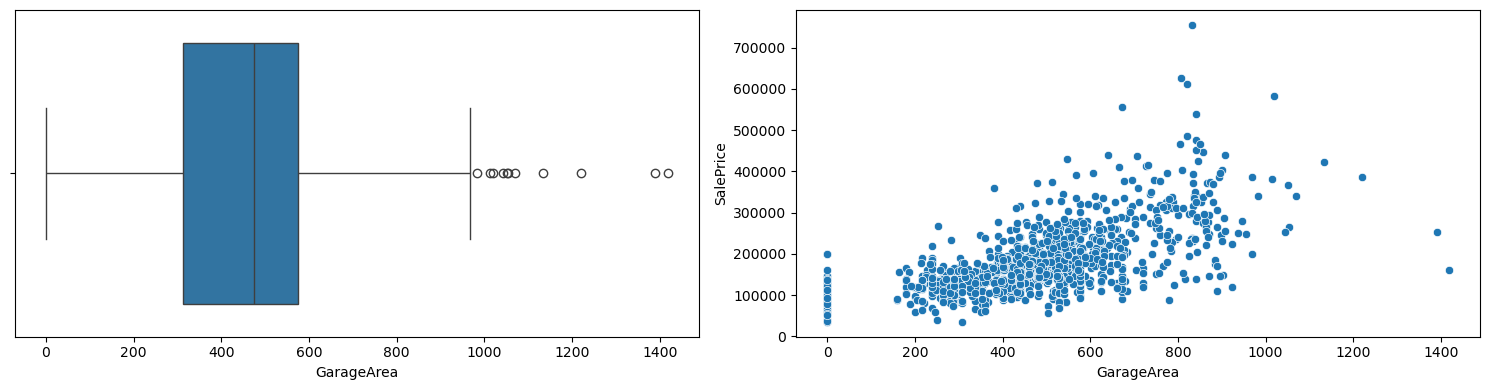

Text(0.5, 1.0, 'Prix fonction de la superficie du sous-sol')

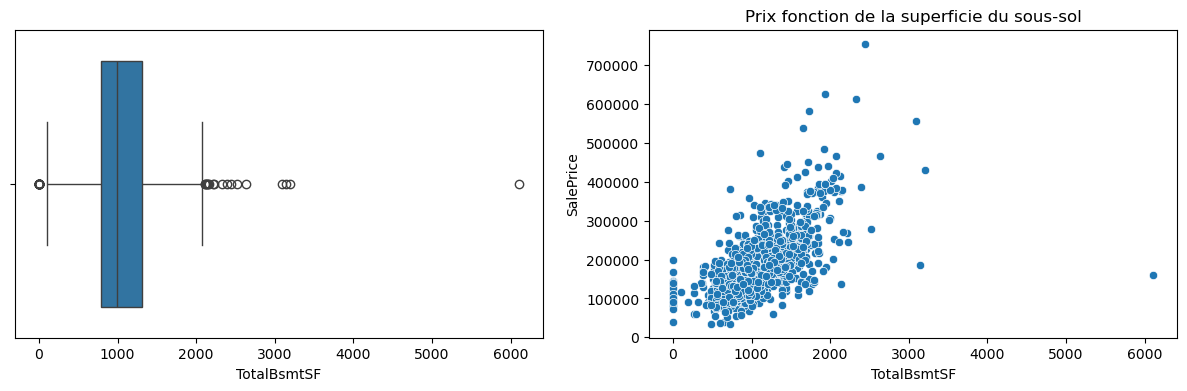

In [1189]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.boxplot(df, x="GarageArea", ax=axs[0])
sns.scatterplot(df, x="GarageArea", y="SalePrice", ax=axs[1])
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.boxplot(df, x="TotalBsmtSF", ax=axs[0])
sns.scatterplot(df, x="TotalBsmtSF", y="SalePrice", ax=axs[1])
axs[1].set_title('Prix fonction de la superficie du sous-sol')

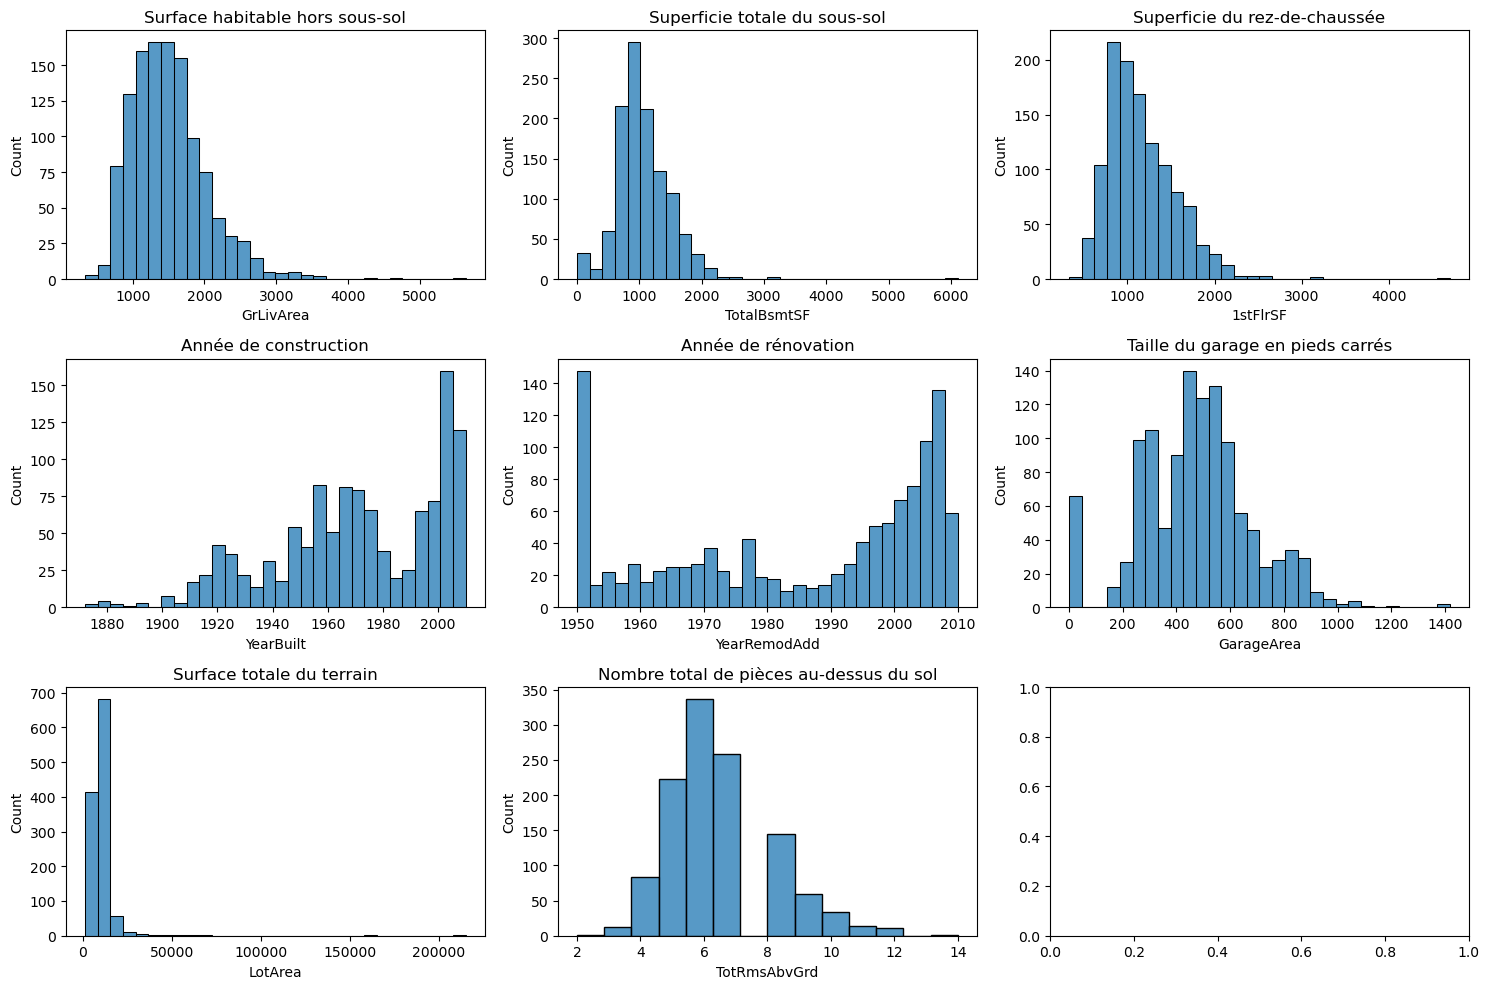

In [1190]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
sns.histplot(df, x="GrLivArea", bins=30, ax=axs[0, 0])
axs[0, 0].set_title('Surface habitable hors sous-sol')
sns.histplot(df, x="TotalBsmtSF", bins=30, ax=axs[0, 1])
axs[0, 1].set_title('Superficie totale du sous-sol')
sns.histplot(df, x="1stFlrSF", bins=30, ax=axs[0, 2])
axs[0, 2].set_title('Superficie du rez-de-chaussée')
sns.histplot(df, x="YearBuilt", bins=30, ax=axs[1, 0])
axs[1, 0].set_title('Année de construction')
sns.histplot(df, x="YearRemodAdd", bins=30, ax=axs[1, 1])
axs[1, 1].set_title('Année de rénovation')
sns.histplot(df, x="GarageArea", bins=30, ax=axs[1, 2])
axs[1, 2].set_title('Taille du garage en pieds carrés')
sns.histplot(df, x="LotArea", bins=30, ax=axs[2, 0])
axs[2, 0].set_title('Surface totale du terrain')
sns.histplot(df, x="TotRmsAbvGrd", bins=14, ax=axs[2, 1])
axs[2, 1].set_title('Nombre total de pièces au-dessus du sol')
fig.tight_layout()

In [1191]:
from sklearn.model_selection import train_test_split

if(submit == False):
   X_train, X_test, y_train, y_test = train_test_split(df, df["SalePrice"], test_size=0.2)
else:
   X_train = df.drop("SalePrice", axis=1)
   y_train = df["SalePrice"]
   X_test = df_test


### Preprocessing

In [1192]:
# Outliers removal
# ----

# remove outliers according to GrLivArea
from sklearn.neighbors import LocalOutlierFactor

detection_model = LocalOutlierFactor(n_neighbors=10, contamination=0.01)
outliers = detection_model.fit_predict(X_train[["GrLivArea", "SalePrice"]])
# plt.scatter(df["GrLivArea"], df["SalePrice"], c=outliers, cmap="bwr_r")
# plt.show()

# Filtering rows where series_filter is -1
X_train = X_train[outliers == 1].sort_values(by=['GrLivArea'])

# remove outliers according to LotArea

detection_model = LocalOutlierFactor(n_neighbors=30, contamination=0.01)
outliers = detection_model.fit_predict(X_train[["LotArea", "SalePrice"]])
# plt.scatter(df["LotArea"], df["SalePrice"], c=outliers, cmap="bwr_r")
# plt.show()

# Filtering rows where series_filter is -1
X_train = X_train[outliers == 1].sort_values(by=['LotArea'])

#X_train = X_train.query('GarageArea < 1200 & TotalBsmtSF < 2300')
y_train = X_train["SalePrice"]

# ----
# ----

In [1193]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

# Preprocessing for numerical data


### Ordinal encoding ---

qual_order = ["Po", "Fa", "TA", "Gd", "Ex"]

# We order neighboorhood by average saleprice to attribute it a value
results = df.groupby(['Neighborhood']).agg({'SalePrice': ['mean']}).reset_index()
results.columns = ['Neighborhood', 'SalePrice']
results = results.sort_values(by=['SalePrice']).reset_index()
neighborhood_order = results['Neighborhood']

ordinal_encoder_transformer = Pipeline(steps=[
   ("OrdinalEncoder", OrdinalEncoder(categories=[qual_order, qual_order, neighborhood_order])),
   ("scaler", MinMaxScaler())
])

qual_columns_transformer = ColumnTransformer(transformers=[
   ("Ordinal Transform", ordinal_encoder_transformer, ["ExterQual", "KitchenQual", "Neighborhood"]),
],
remainder="passthrough",
verbose_feature_names_out=False)

# exterQual_pipeline = Pipeline(steps=[
#    ('Transform ExterQual', qual_columns_transformer)
# ])
# X_train = exterQual_pipeline.fit_transform(X_train)
# X_train["ExterQual"].unique()

### --- encoding

columns_transformer = ColumnTransformer(transformers=[
   ("Min-max Scaler", MinMaxScaler(), ["YearBuilt", "YearRemodAdd", "OverallQual", "GarageCars", "FullBath", "YearsSinceRenovation", "Fireplaces"]),
   ("Standard Scaler", StandardScaler(), ["GrLivArea", "1stFlrSF", "LotArea", "TotRmsAbvGrd", "GarageArea"])
],
remainder="passthrough",
verbose_feature_names_out=False)


pipeline = Pipeline(steps=[
   ('Transform ExterQual + KitchenQual', qual_columns_transformer),
   ("Transform other columns", columns_transformer)])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [1194]:
X_train

,YearBuilt,YearRemodAdd,OverallQual,GarageCars,FullBath,YearsSinceRenovation,Fireplaces,GrLivArea,1stFlrSF,LotArea,TotRmsAbvGrd,GarageArea,ExterQual,KitchenQual,Neighborhood,TotalBsmtSF,SalePrice,IsRenovated
842,0.710145,0.333333,0.250,0.25,0.333333,0.000000,0.000000,-1.715431,-1.420769,-1.877577,-2.166481,-0.851269,0.333333,0.333333,0.041667,630,80000,False
397,0.710145,0.866667,0.250,0.25,0.333333,0.306667,0.000000,-1.715431,-1.420769,-1.866449,-2.166481,-0.851269,0.333333,0.666667,0.041667,630,86000,True
1173,0.710145,0.333333,0.375,0.00,0.333333,0.000000,0.000000,-1.715431,-1.420769,-1.864860,-2.166481,-2.248517,0.333333,1.000000,0.041667,630,92000,False
345,0.717391,0.350000,0.500,0.25,0.333333,0.000000,0.000000,-1.008019,-1.823816,-1.831476,-1.538161,-0.958750,0.333333,0.333333,0.083333,483,85400,False
174,0.717391,0.350000,0.375,0.25,0.666667,0.000000,0.000000,-0.383831,-1.420769,-1.831476,-0.281520,-0.880582,0.333333,0.333333,0.083333,630,112000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,0.637681,0.950000,0.625,0.50,0.666667,0.240000,0.333333,1.136017,2.524706,4.066365,1.603441,0.218652,0.333333,0.666667,0.416667,585,242000,True
673,0.688406,0.283333,0.375,0.50,0.666667,0.000000,0.000000,1.248965,0.032394,4.304368,0.346800,0.379873,0.333333,0.333333,0.750000,1013,185000,False
215,0.594203,0.916667,0.625,0.50,0.333333,0.266667,0.666667,-0.262956,0.588983,6.667592,-0.909840,-0.103790,0.333333,0.333333,0.750000,1385,241500,True
40,0.789855,0.616667,0.875,0.75,0.000000,0.506667,0.333333,0.686206,1.902314,9.203641,-0.909840,2.119105,0.666667,0.666667,0.833333,1842,385000,True


### Training

544   -72016.646667
624    13069.000000
984     2970.940000
641      852.280000
79     14118.993333
Name: SalePrice, dtype: float64


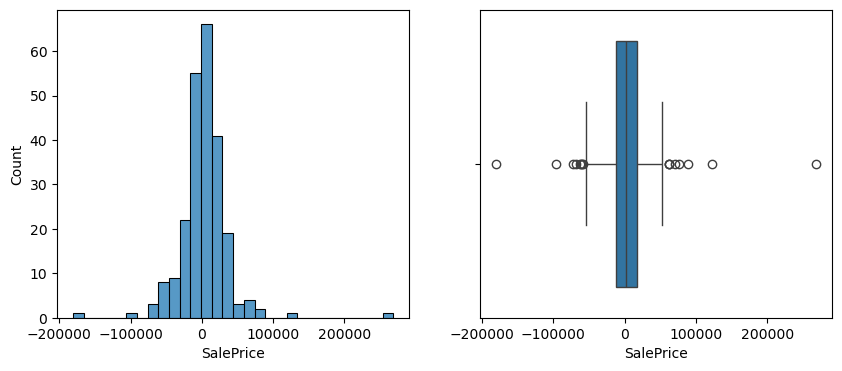

MAE = 21359.1984086629


In [1195]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

predictio_colmuns = [
   "LotArea", 
   "GrLivArea", 
   "YearBuilt", 
   "FullBath", 
   "GarageArea",
   "TotRmsAbvGrd", 
   "OverallQual", 
   "ExterQual", 
   "KitchenQual",
   #"YearsSinceRenovation",
   #"YearRemodAdd",
   "IsRenovated",
   "Neighborhood", 
   #"Fireplaces"
]
X_train = X_train[predictio_colmuns]

# model = LinearRegression()
model = RandomForestRegressor(criterion="squared_error", n_estimators=150)

if(make_grid_search):
   param_grid_random_forest = {
      "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
      "n_estimators": [100, 150, 200, 300]
   }


   grid_search = GridSearchCV(estimator=model, param_grid=param_grid_random_forest, cv=5, scoring="neg_mean_absolute_error")
   grid_search.fit(X_train, y_train)
   params = grid_search.cv_results_["params"]
   scores = grid_search.cv_results_["mean_test_score"]
   grid_search_results = pd.DataFrame(params)
   grid_search_results["score"] = scores
   grid_search_results
   grid_search_heatmap = grid_search_results.pivot(index='n_estimators', columns='criterion', values="score")
   sns.heatmap(grid_search_heatmap, annot=True, fmt=".3f", cmap="viridis")
   plt.show()
   print(f"Meilleurs paramètres : {grid_search.best_params_}")
   print(f"Meilleurs score : {grid_search.best_score_}")
else:
   model.fit(X_train, y_train)
   predictions = model.predict(X_test[predictio_colmuns])

   if(submit == False):
      # plot histogram of the difference between predictions and expected values
      differences = predictions - y_test
      print(differences.head())
      fix, axs = plt.subplots(1, 2, figsize=(10, 4))
      sns.histplot(differences, bins=30, ax=axs[0])
      sns.boxplot(differences, orient="h", ax=axs[1])
      plt.show()

      # compute mean absolute error
      mae = mean_absolute_error(predictions, y_test)
      print(f"MAE = {mae}")
   else:
      submissions = pd.DataFrame()
      submissions["SalePrice"] = predictions
      submissions.index.name = "ID"
      submissions
      submissions.to_csv("submission.csv")


In [1196]:
type(differences)
indices = differences[differences < -100000]
indices.index.values
outliers = df.iloc[indices.index.values]
outliers




,OverallQual,GrLivArea,TotalBsmtSF,1stFlrSF,YearBuilt,YearRemodAdd,GarageCars,GarageArea,FullBath,TotRmsAbvGrd,KitchenQual,Fireplaces,LotArea,Neighborhood,ExterQual,SalePrice,IsRenovated,YearsSinceRenovation
355,10,2402,3094,2402,2008,2008,3,672,2,10,Ex,2,15431,NridgHt,Ex,555000,False,0
